In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-07-25 23:30:16


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf

from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
from   invisible_cities.types.ic_types import Counter
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.icaro.pmaps_mpl import plot_s2si_map

In [4]:
import invisible_cities.icaro.mpl_functions as mpl

In [5]:
import invisible_cities.evm.event_model as evm

In [6]:
from invisible_cities.evm.pmaps import S12
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si

In [7]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [8]:
run_number = -4446
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [15]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [16]:
RWF_file = os.path.join(os.environ['IC_DATA'], 'MC_PreProd_July_2017',
                        'dst_NEXT_v1_00_05_Tl_ACTIVE_0_0_7bar_RWF_10.h5')
print('RWF file = {}'.format(RWF_file))

RWF file = /Users/jjgomezcadenas/Projects/ICDATA/MC_PreProd_July_2017/dst_NEXT_v1_00_05_Tl_ACTIVE_0_0_7bar_RWF_10.h5


In [17]:
pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
NEVT, pmtrwf, sipmrwf, _ = tbl.get_rwf_vectors(h5rwf)
sp = tbl.get_sensor_params_from_vectors(pmtrwf, sipmrwf)
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 48000
nsipm: 1792
sipmwl: 1200



### Reconstruction Parameters

In [18]:
h5rwf = tb.open_file(RWF_file,'r')

In [19]:
calib_vectors = CalibVectors(channel_id = DataPMT.ChannelID.values,
                             coeff_blr = abs(DataPMT.coeff_blr   .values),
                             coeff_c = abs(DataPMT.coeff_c   .values),
                             adc_to_pes = DataPMT.adc_to_pes.values,
                             adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                             pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist())


deconv_params = DeconvParams(n_baseline = 45000,
                              thr_trigger = 5)

s1par = S12Params(time = minmax(min    = 99 * units.mus,
                           max    = 101 * units.mus),
                           stride = 4,
                           length = minmax(min = 6, max = 20),  #150 ns -- 500 ns
                           rebin  = False)

s2par = S12Params(time = minmax(min    = 101 * units.mus,
                           max    = 1199 * units.mus),
                           stride = 40,
                           length = minmax(min = 120, max = 1e5),  # 4 mus --
                           rebin  = True)

thresholds = ThresholdParams(thr_s1=0.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=15*units.pes)



In [20]:
event = 0

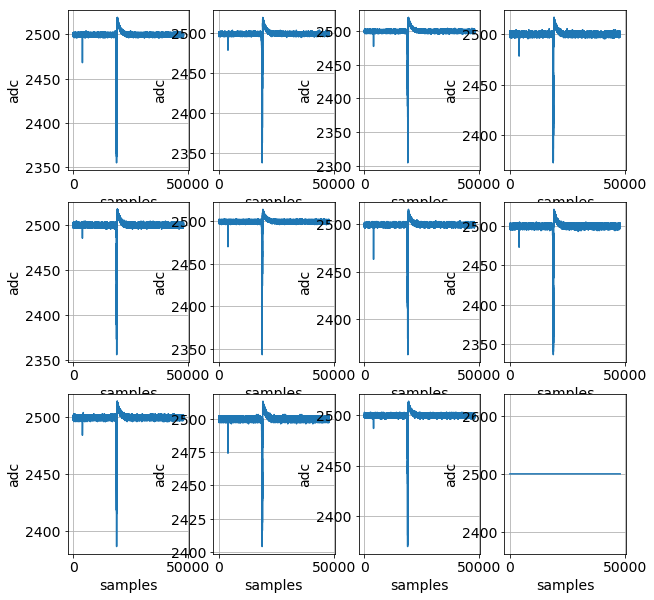

In [21]:
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))

#### Deconvolution

In [22]:
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)

#### csum

In [23]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

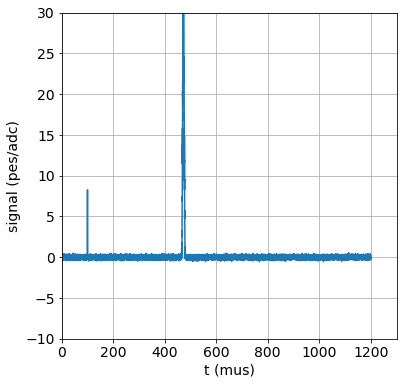

In [24]:
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))

#### S1 and S2

In [25]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)

In [26]:
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())


In [27]:
s1

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =      0.3 mus , energy =     55.3 pes
        height =      8.3 pes tmin-tmax = minmax(min=100.05, max=100.4) mus  

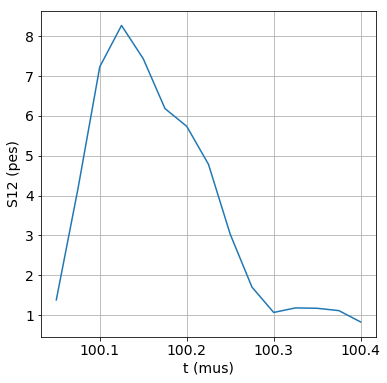

In [28]:
plot_s12(s1)

In [29]:
s2

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =     13.5 mus , energy =   9671.3 pes
        height =   1639.3 pes tmin-tmax = minmax(min=465.9375, max=479.4125) mus  

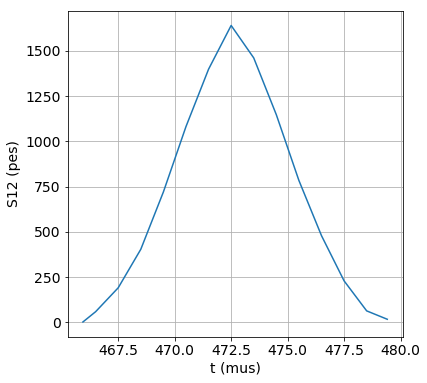

In [30]:
plot_s12(s2)

#### S2Si

In [31]:
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)

In [32]:
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)

In [33]:
s2si

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =     13.5 mus , energy =   9671.3 pes
        height =   1639.3 pes tmin-tmax = minmax(min=465.9375, max=479.4125) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1602, 1608, 1609, 1610, 1611, 1616, 1617, 1618, 1619, 1620, 1625, 1626, 1627, 1634)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1602
    sipm waveform (zs) = Peak(samples = 6 width =      7.0 mus , energy =     23.4 pes
        height =      7.7 pes tmin-tmax = minmax(min=468.5, max=475.5) mus 
peak number = 0: sipm number = 1608
    sipm waveform (zs) = Peak(samples = 4 width =      3.0 mus , energy =     18.4 pes
        height =      7.0 pes tmin-tmax = minmax(min=472.5, max=475.5) mus 
peak number = 0: sipm number = 1609
    sipm waveform (zs) = Peak(samples = 11 width =    

In [35]:
s2si.number_of_peaks

1

In [36]:
s2si.sipms_in_peak(0)

(1602,
 1608,
 1609,
 1610,
 1611,
 1616,
 1617,
 1618,
 1619,
 1620,
 1625,
 1626,
 1627,
 1634)

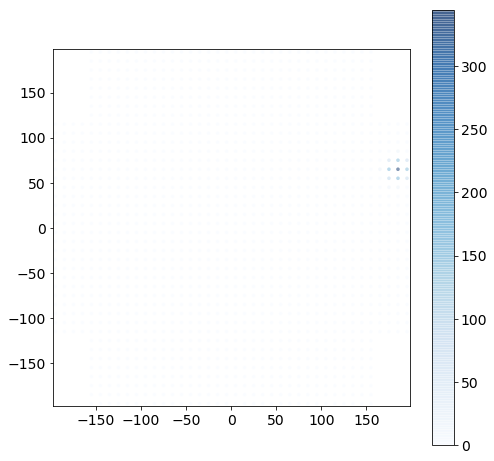

In [37]:
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 16 width =      0.4 mus , energy =     94.6 pes
        height =     14.3 pes tmin-tmax = minmax(min=100.05, max=100.425) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =     17.6 mus , energy =  16352.0 pes
        height =   2387.7 pes tmin-tmax = minmax(min=585.625, max=603.1750000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =     17.6 mus , energy =  16352.0 pes
        height =   2387.7 pes tmin-tmax = minmax(min=585.625, max=603.1750000000001) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1496, 1504, 1505, 1512, 1513, 1520, 1521, 1528, 1574, 1575, 1582, 1583, 1590, 1591, 1599)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1496
    sipm waveform (zs) = Peak(samples = 7 width =      

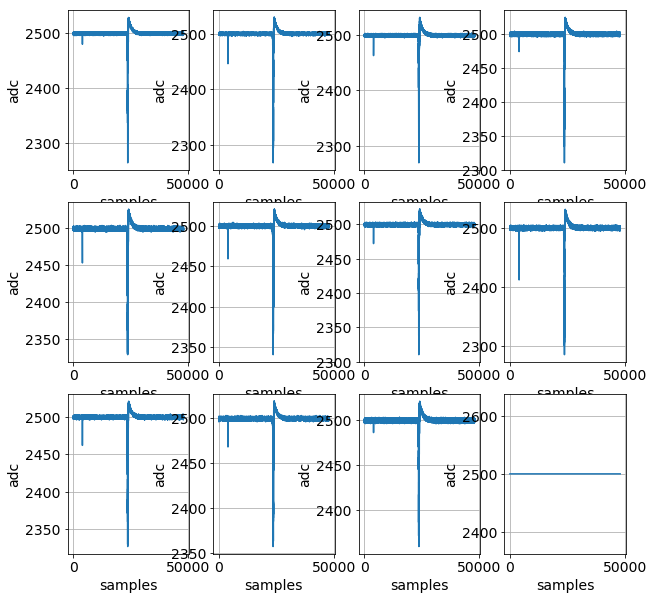

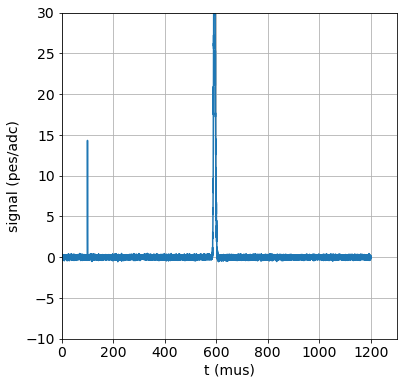

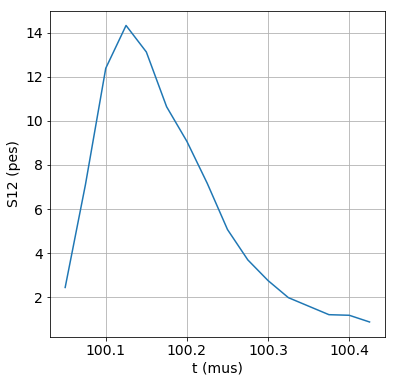

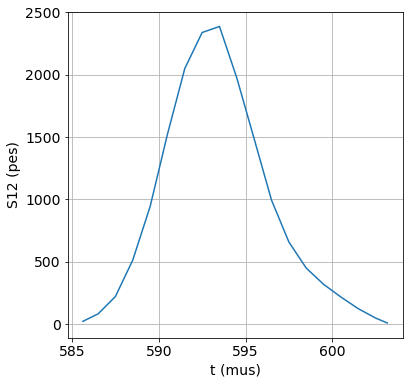

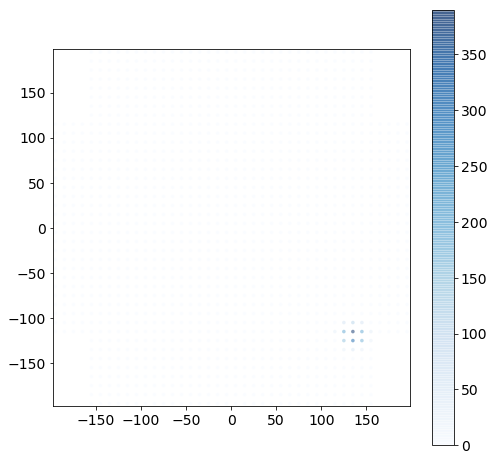

In [38]:
event = 1
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      0.2 mus , energy =     17.7 pes
        height =      3.2 pes tmin-tmax = minmax(min=100.075, max=100.3) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.5 mus , energy =   6265.1 pes
        height =   1455.5 pes tmin-tmax = minmax(min=327.875, max=336.33750000000003) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      8.5 mus , energy =   6265.1 pes
        height =   1455.5 pes tmin-tmax = minmax(min=327.875, max=336.33750000000003) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (419, 420, 427, 428, 429, 435, 436, 707, 708, 715, 716)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 419
    sipm waveform (zs) = Peak(samples = 5 width =      4.0 mus , energy =     15.5 pes
   

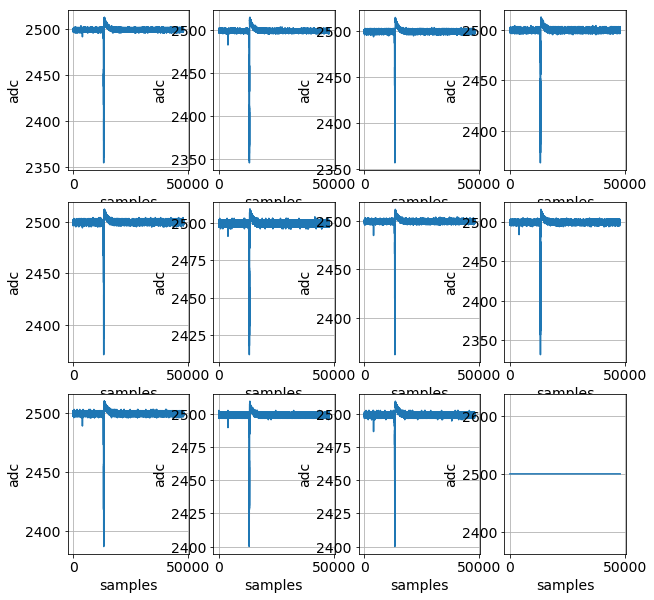

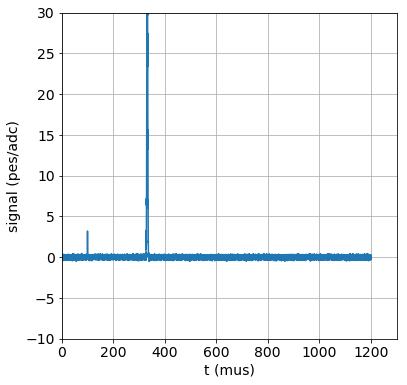

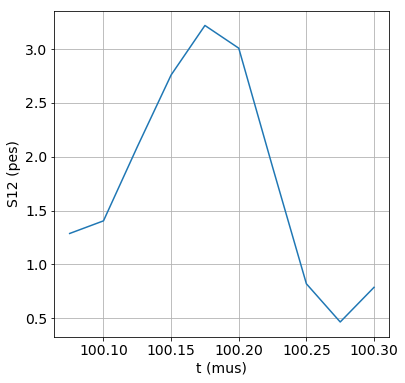

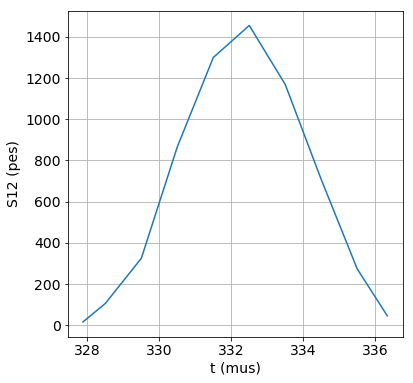

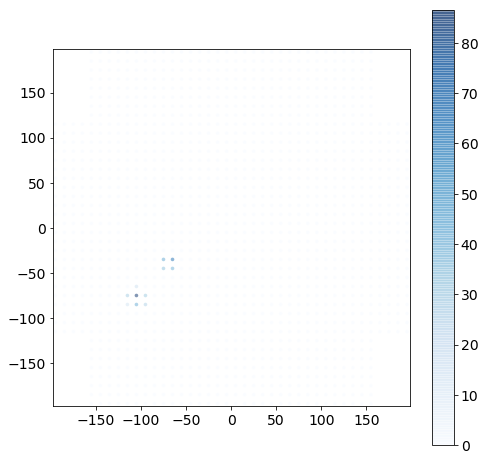

In [39]:
event = 2
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      0.2 mus , energy =     28.6 pes
        height =      5.0 pes tmin-tmax = minmax(min=100.075, max=100.325) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =     17.6 mus , energy =  10954.4 pes
        height =   1986.7 pes tmin-tmax = minmax(min=308.77500000000003, max=326.4125) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 19 width =     17.6 mus , energy =  10954.4 pes
        height =   1986.7 pes tmin-tmax = minmax(min=308.77500000000003, max=326.4125) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1140, 1141, 1147, 1148, 1149, 1150, 1408, 1409, 1416, 1417, 1479)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1140
    sipm waveform (zs) = Peak(samples = 12 width =     16.0 mus , energy =

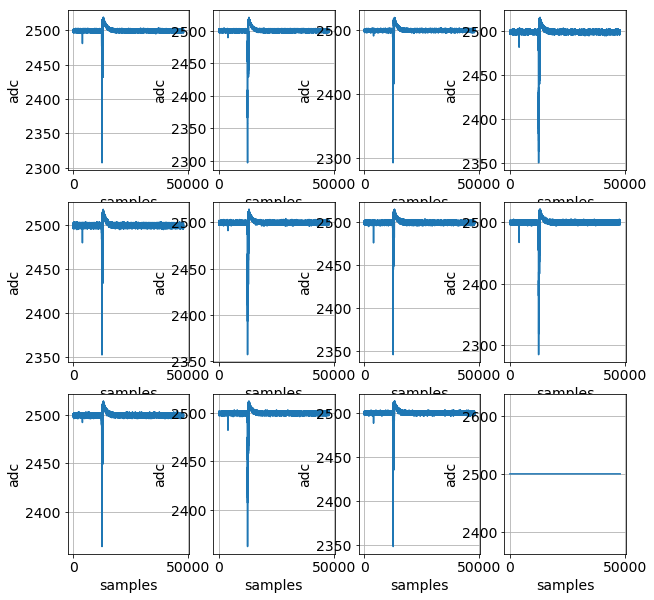

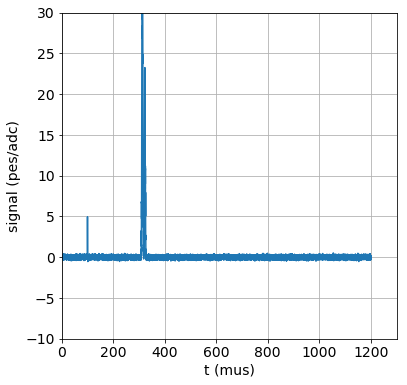

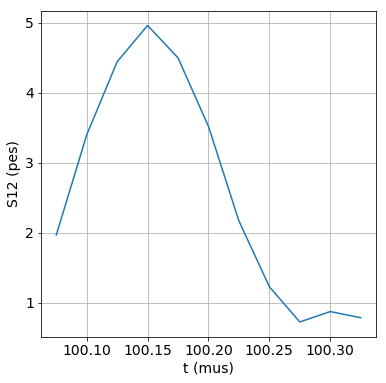

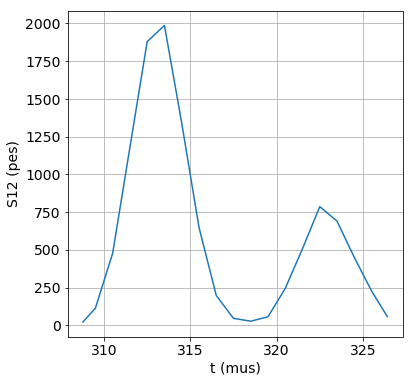

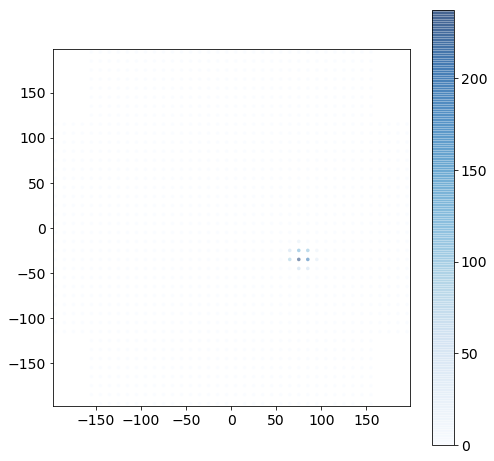

In [40]:
event = 3
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 0)

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 74 width =     72.7 mus , energy =  96632.5 pes
        height =   6645.6 pes tmin-tmax = minmax(min=436.7375, max=509.4125) mus  



ZeroDivisionError: float modulo

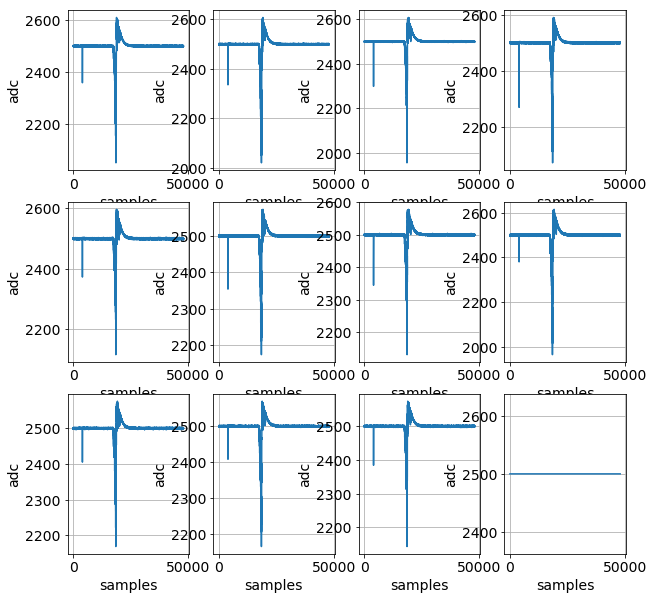

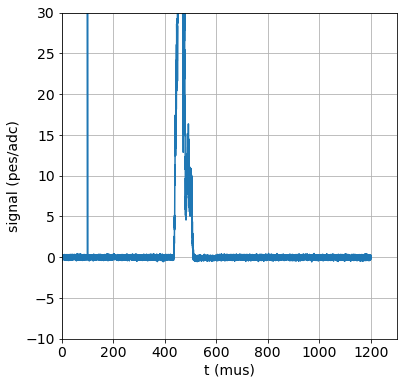

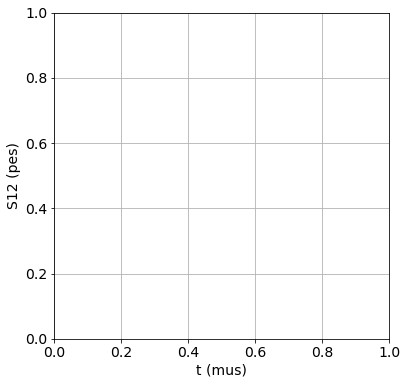

In [41]:
event = 4
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 7 width =      0.1 mus , energy =     14.9 pes
        height =      2.8 pes tmin-tmax = minmax(min=100.075, max=100.22500000000001) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.4 mus , energy =   3372.0 pes
        height =    689.1 pes tmin-tmax = minmax(min=496.96250000000003, max=506.325) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 11 width =      9.4 mus , energy =   3372.0 pes
        height =    689.1 pes tmin-tmax = minmax(min=496.96250000000003, max=506.325) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (1493, 1494, 1501, 1502, 1503, 1509, 1510, 1511)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 1493
    sipm waveform (zs) = Peak(samples = 5 width =      5.0 mus , energy =     16.6 p

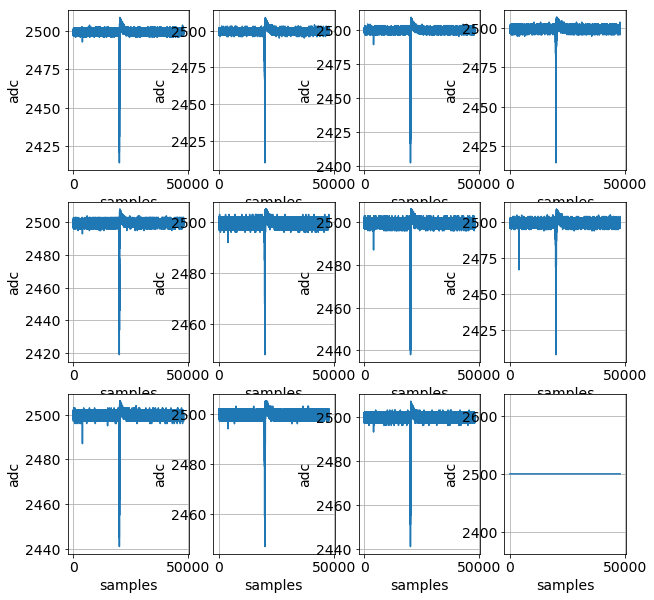

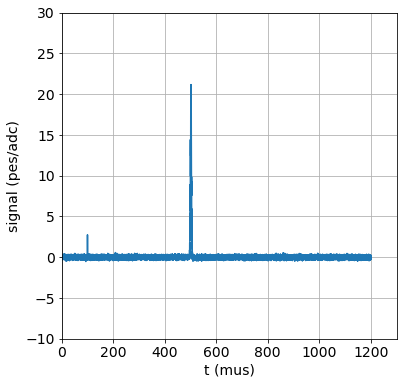

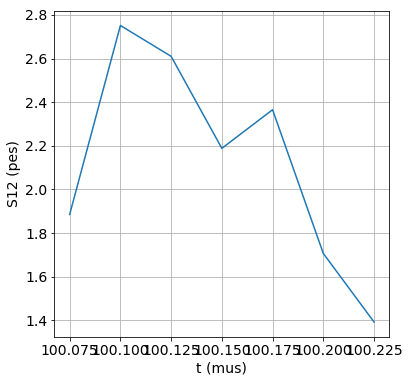

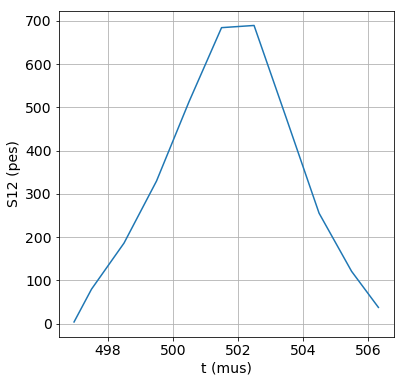

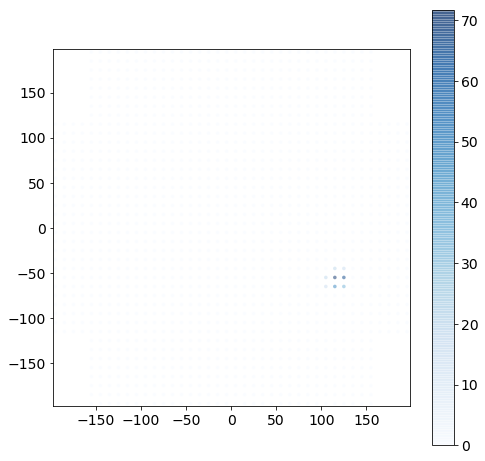

In [41]:
event = 5
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 16 width =      0.4 mus , energy =     65.5 pes
        height =      9.3 pes tmin-tmax = minmax(min=100.05, max=100.425) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =     13.6 mus , energy =  20346.3 pes
        height =   3818.9 pes tmin-tmax = minmax(min=388.9125, max=402.46250000000003) mus  

S2 (number of peaks = 1)
peak number = 0: Peak(samples = 15 width =     13.6 mus , energy =  20346.3 pes
        height =   3818.9 pes tmin-tmax = minmax(min=388.9125, max=402.46250000000003) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 0: nsipm in peak = (404, 411, 412, 413, 418, 419, 420, 421, 422, 427, 428, 429, 430, 436, 437)
--------------------------------------------------------------------------------
SiPMs Waveforms

peak number = 0: sipm number = 404
    sipm waveform (zs) = Peak(samples = 5 width =      4.0 mus , en

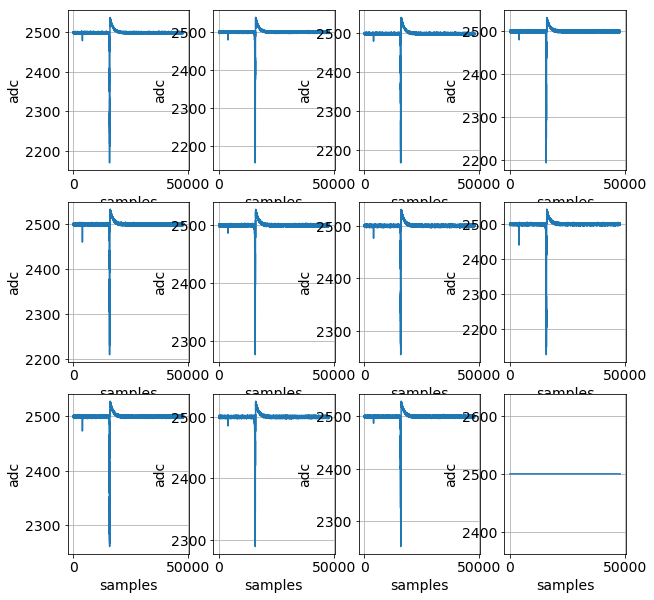

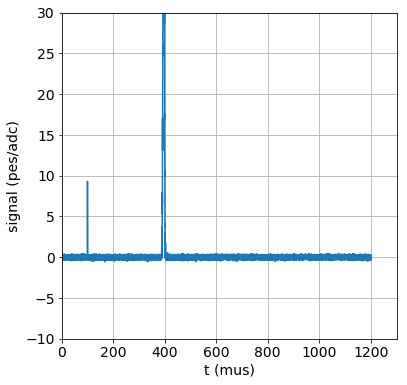

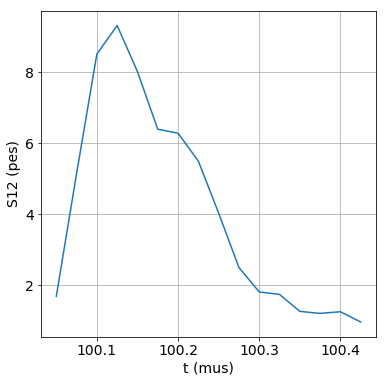

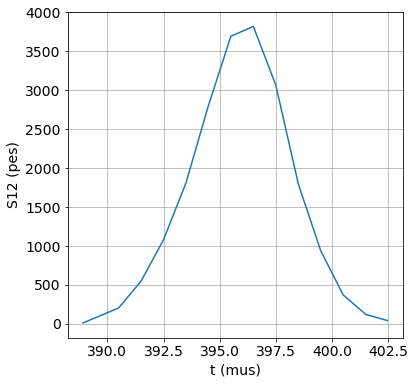

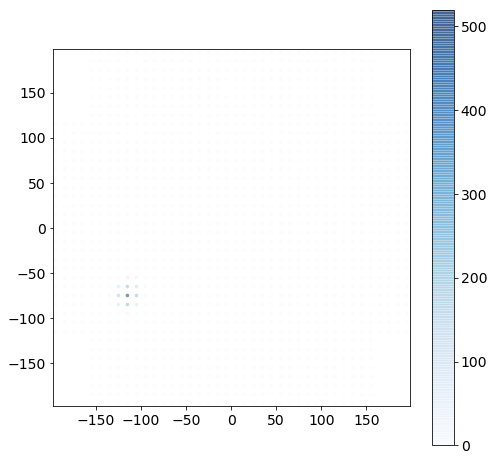

In [42]:
event = 6
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 13 width =      0.3 mus , energy =     25.1 pes
        height =      4.2 pes tmin-tmax = minmax(min=100.075, max=100.375) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 7 width =      5.5 mus , energy =   2895.6 pes
        height =    940.4 pes tmin-tmax = minmax(min=202.6875, max=208.1625) mus  
peak number = 1: Peak(samples = 9 width =      7.5 mus , energy =  13129.4 pes
        height =   3905.7 pes tmin-tmax = minmax(min=238.8, max=246.275) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 7 width =      5.5 mus , energy =   2895.6 pes
        height =    940.4 pes tmin-tmax = minmax(min=202.6875, max=208.1625) mus  
peak number = 1: Peak(samples = 9 width =      7.5 mus , energy =  13129.4 pes
        height =   3905.7 pes tmin-tmax = minmax(min=238.8, max=246.275) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty peaks

peak number = 

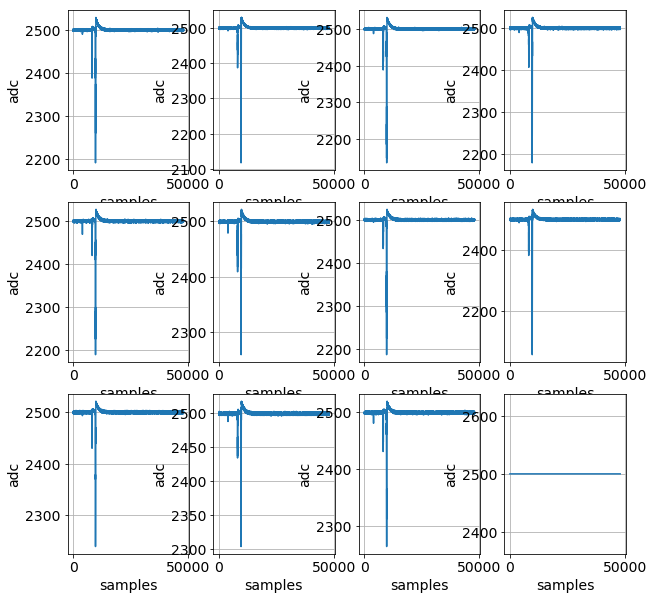

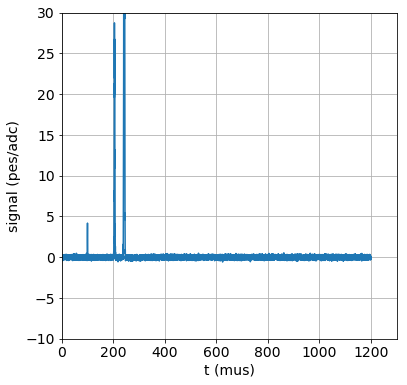

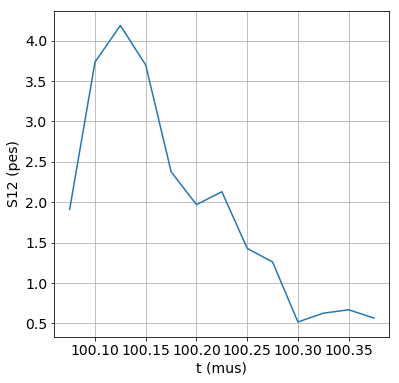

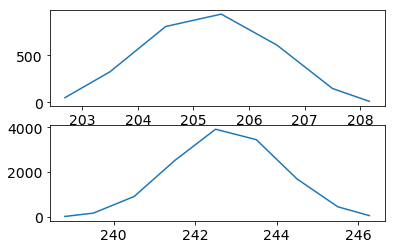

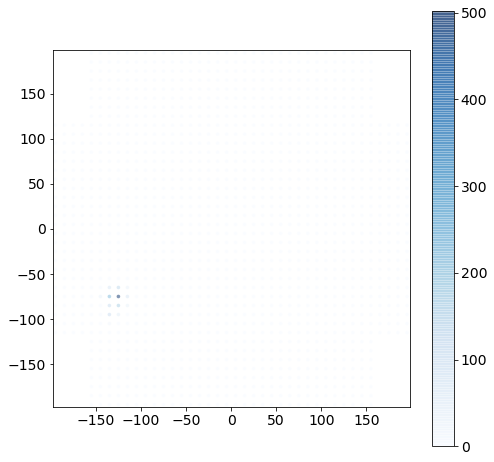

In [43]:
event = 7
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)

S1 (number of peaks = 1)
peak number = 0: Peak(samples = 10 width =      0.2 mus , energy =     22.8 pes
        height =      3.6 pes tmin-tmax = minmax(min=100.05, max=100.275) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 11 width =      9.8 mus , energy =   6136.3 pes
        height =   1325.9 pes tmin-tmax = minmax(min=424.55, max=434.3) mus  
peak number = 1: Peak(samples = 10 width =      8.7 mus , energy =   1805.5 pes
        height =    417.1 pes tmin-tmax = minmax(min=459.58750000000003, max=468.2625) mus  

S2 (number of peaks = 2)
peak number = 0: Peak(samples = 11 width =      9.8 mus , energy =   6136.3 pes
        height =   1325.9 pes tmin-tmax = minmax(min=424.55, max=434.3) mus  
peak number = 1: Peak(samples = 10 width =      8.7 mus , energy =   1805.5 pes
        height =    417.1 pes tmin-tmax = minmax(min=459.58750000000003, max=468.2625) mus  
--------------------------------------------------------------------------------
SiPMs for non-empty 

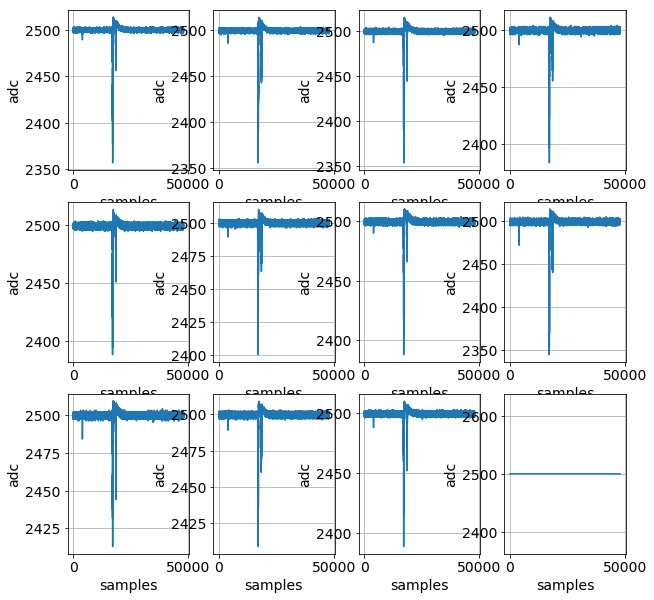

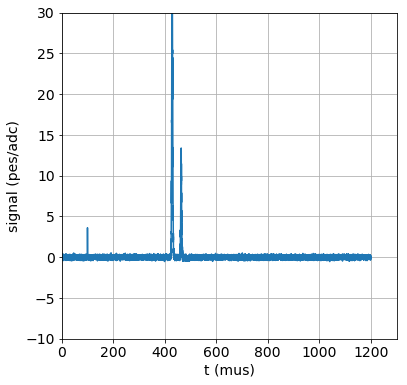

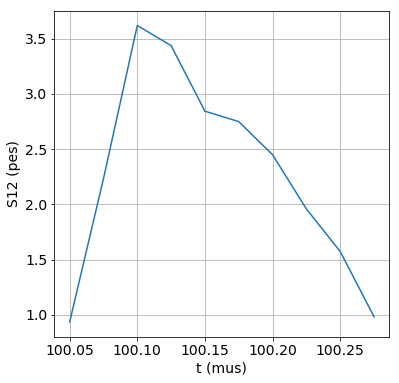

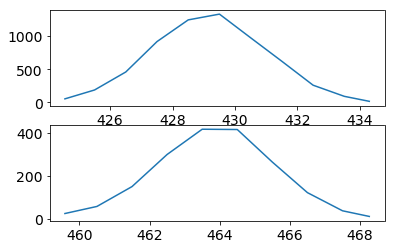

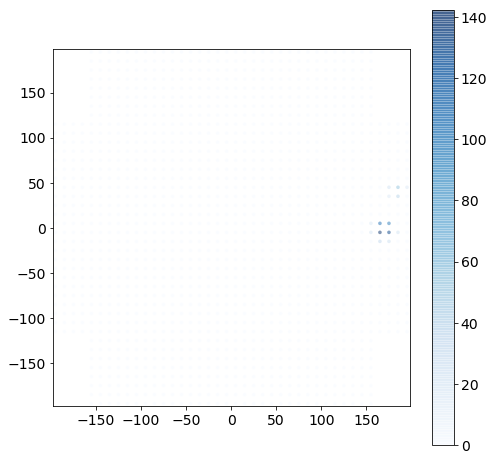

In [44]:
event = 8
mpl.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=1200, figsize=(10,10))
CWF = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr,
                         pmt_active  = pmt_active,
                         n_baseline  = deconv_params.n_baseline,
                         thr_trigger = deconv_params.thr_trigger)
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 1300,
                        signal_min =    -10,
                        signal_max =  30,
                        figsize=(6,6))
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)
s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=thresholds.thr_s1)
s1 = cpf.find_s1(csum, s1_indx, **s1par._asdict())
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())
print(s1)
print(s2)
plot_s12(s1)
plot_s12(s2)
sipmzs= cpf.signal_sipm(sipmrwf[event], adc_to_pes_sipm,
                           thr=thresholds.thr_sipm, n_MAU=100)
s2si = cpf.find_s2si(sipmzs, s2.s2d, thr = thresholds.thr_SIPM)
print(s2si)
print(s2si.number_of_peaks)
plot_s2si_map(s2si, run_number=-4446)